# ML Project: Profit Prediction & High-Selling Product Analysis

This notebook covers data cleaning, profit prediction, high-selling product prediction, and visualization using the provided sales data.

In [2]:
# 3. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
import category_encoders as ce

In [3]:
# 4. Load and Inspect Data
df = pd.read_csv('data.csv', encoding='utf-8')
display(df.head())
df.info()
df.describe()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,11/9/2013,11/12/2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2013-152156,11/9/2013,11/12/2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2013-138688,6/13/2013,6/17/2013,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2012-108966,10/11/2012,10/18/2012,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2012-108966,10/11/2012,10/18/2012,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [4]:
# 5. Data Cleaning and Preprocessing
# Convert date columns to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

# Remove duplicates
df = df.drop_duplicates()

# Handle missing values
df = df.dropna()

# Clean categorical columns (strip whitespace, lower case)
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = df[col].astype(str).str.strip()

# Check again
display(df.head())
df.info()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2013-138688,2013-06-13,2013-06-17,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [5]:
# 6. Feature Engineering
# Extract year and month from Order Date
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month

# Aggregate sales and profit by Product ID for high-selling prediction
df['Total_Sales_Product'] = df.groupby('Product ID')['Sales'].transform('sum')
df['Total_Profit_Product'] = df.groupby('Product ID')['Profit'].transform('sum')
df['Total_Quantity_Product'] = df.groupby('Product ID')['Quantity'].transform('sum')

# Encode categorical variables using LabelEncoder for simplicity
le = LabelEncoder()
for col in ['Category', 'Sub-Category', 'Region', 'Segment', 'Ship Mode']:
    df[col+'_enc'] = le.fit_transform(df[col])

display(df.head())

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Year,Month,Total_Sales_Product,Total_Profit_Product,Total_Quantity_Product,Category_enc,Sub-Category_enc,Region_enc,Segment_enc,Ship Mode_enc
0,1,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,2013,11,1263.957,-56.3214,12,0,4,2,0,2
1,2,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,2013,11,10637.528,1927.4420,51,0,5,2,0,2
2,3,CA-2013-138688,2013-06-13,2013-06-17,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,2013,6,153.510,64.4011,23,1,10,3,1,2
3,4,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,2012,10,7242.768,-532.7613,29,0,16,2,0,3
4,5,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,2012,10,301.968,63.7488,24,1,14,2,0,3


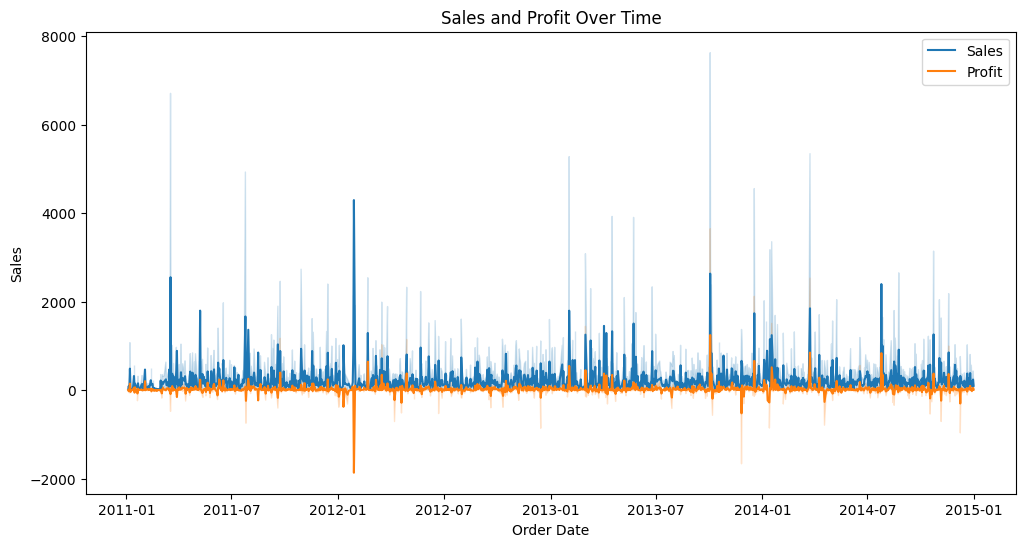

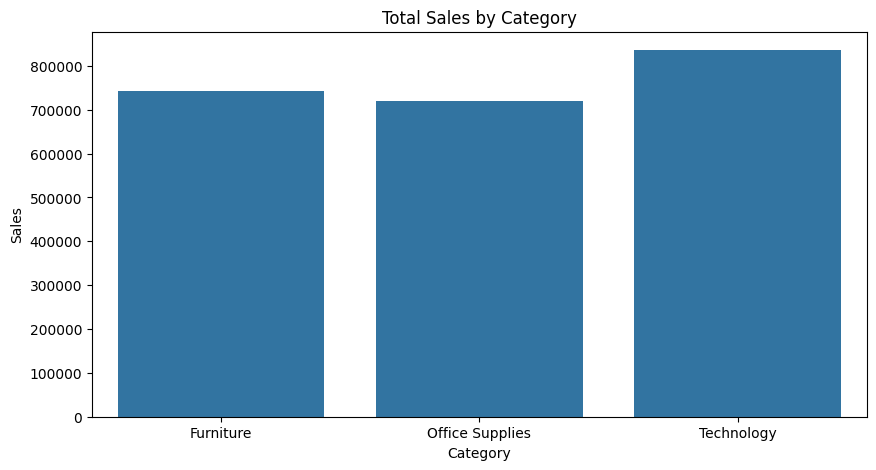

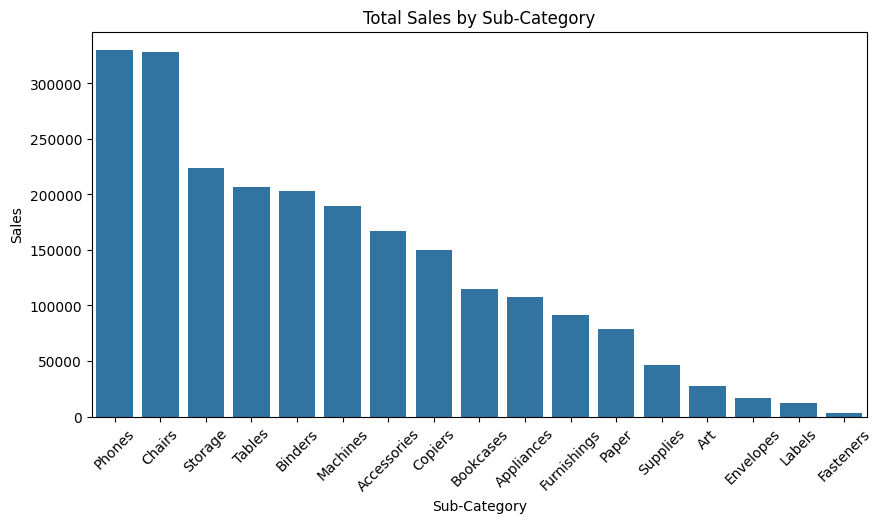

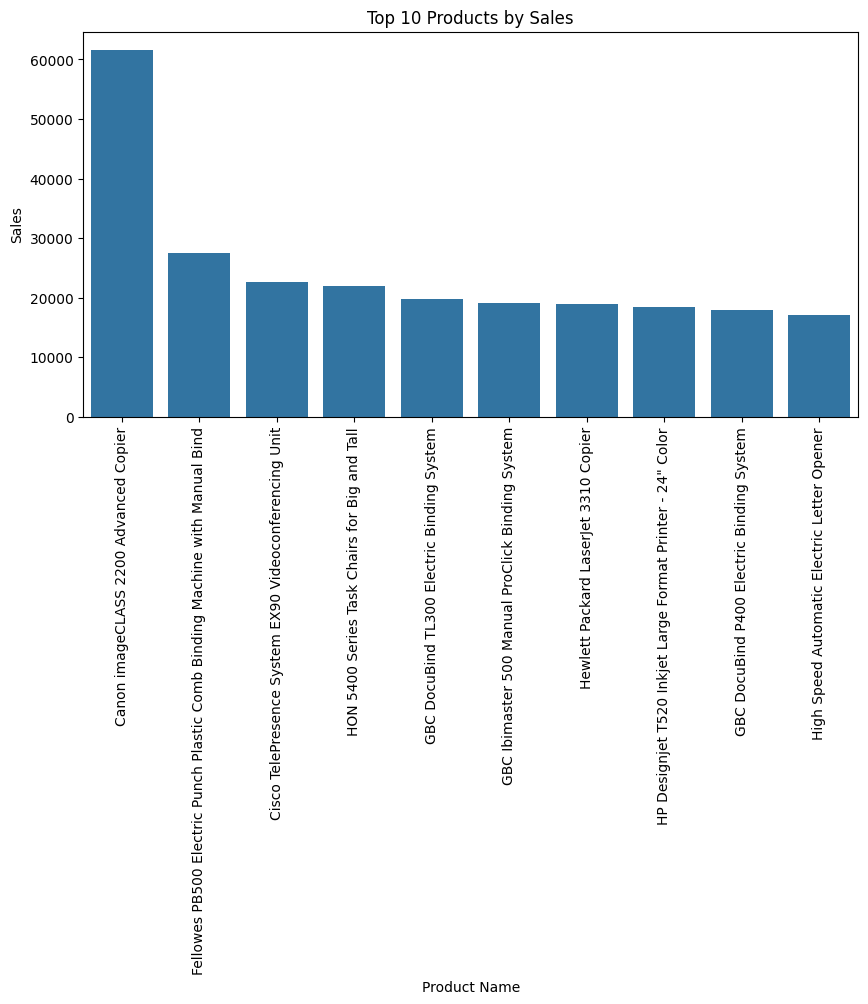

In [6]:
# 7. Exploratory Data Analysis and Visualization
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Order Date', y='Sales', label='Sales')
sns.lineplot(data=df, x='Order Date', y='Profit', label='Profit')
plt.title('Sales and Profit Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=df.groupby('Category').sum(numeric_only=True).reset_index(), x='Category', y='Sales')
plt.title('Total Sales by Category')
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=df.groupby('Sub-Category').sum(numeric_only=True).reset_index().sort_values('Sales', ascending=False), x='Sub-Category', y='Sales')
plt.title('Total Sales by Sub-Category')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=df.groupby('Product Name').sum(numeric_only=True).reset_index().sort_values('Sales', ascending=False).head(10), x='Product Name', y='Sales')
plt.title('Top 10 Products by Sales')
plt.xticks(rotation=90)
plt.show()

In [7]:
# 8. Predict Future Profits (Regression Model)
# Use features for regression
target = 'Profit'
features = ['Sales', 'Quantity', 'Discount', 'Year', 'Month',
            'Category_enc', 'Sub-Category_enc', 'Region_enc', 'Segment_enc', 'Ship Mode_enc',
            'Total_Sales_Product', 'Total_Quantity_Product']

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

print('MSE:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))

MSE: 14195.127619243329
R2 Score: 0.707227167183001


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1622, number of negative: 6373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 7995, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202877 -> initscore=-1.368410
[LightGBM] [Info] Start training from score -1.368410
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1616
           1       0.98      0.97      0.98       383

    accuracy                           0.99      1999
   macro avg       0.99      0.98      0.98      1999
weighted avg       0.99      0.99      0.99      1999



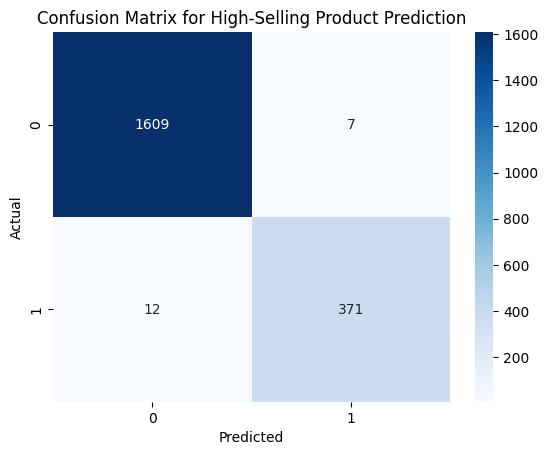

In [8]:
# 9. Predict High Selling Products (Classification Model)
# Define high-selling as top 20% by Total_Sales_Product
sales_threshold = df['Total_Sales_Product'].quantile(0.8)
df['High_Seller'] = (df['Total_Sales_Product'] >= sales_threshold).astype(int)

features_cls = features.copy()
features_cls.remove('Total_Sales_Product')  # Remove to avoid leakage
X_cls = df[features_cls]
y_cls = df['High_Seller']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# LightGBM Classifier
lgbm_cls = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgbm_cls.fit(X_train_cls, y_train_cls)
y_pred_cls = lgbm_cls.predict(X_test_cls)

print(classification_report(y_test_cls, y_pred_cls))
sns.heatmap(confusion_matrix(y_test_cls, y_pred_cls), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for High-Selling Product Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

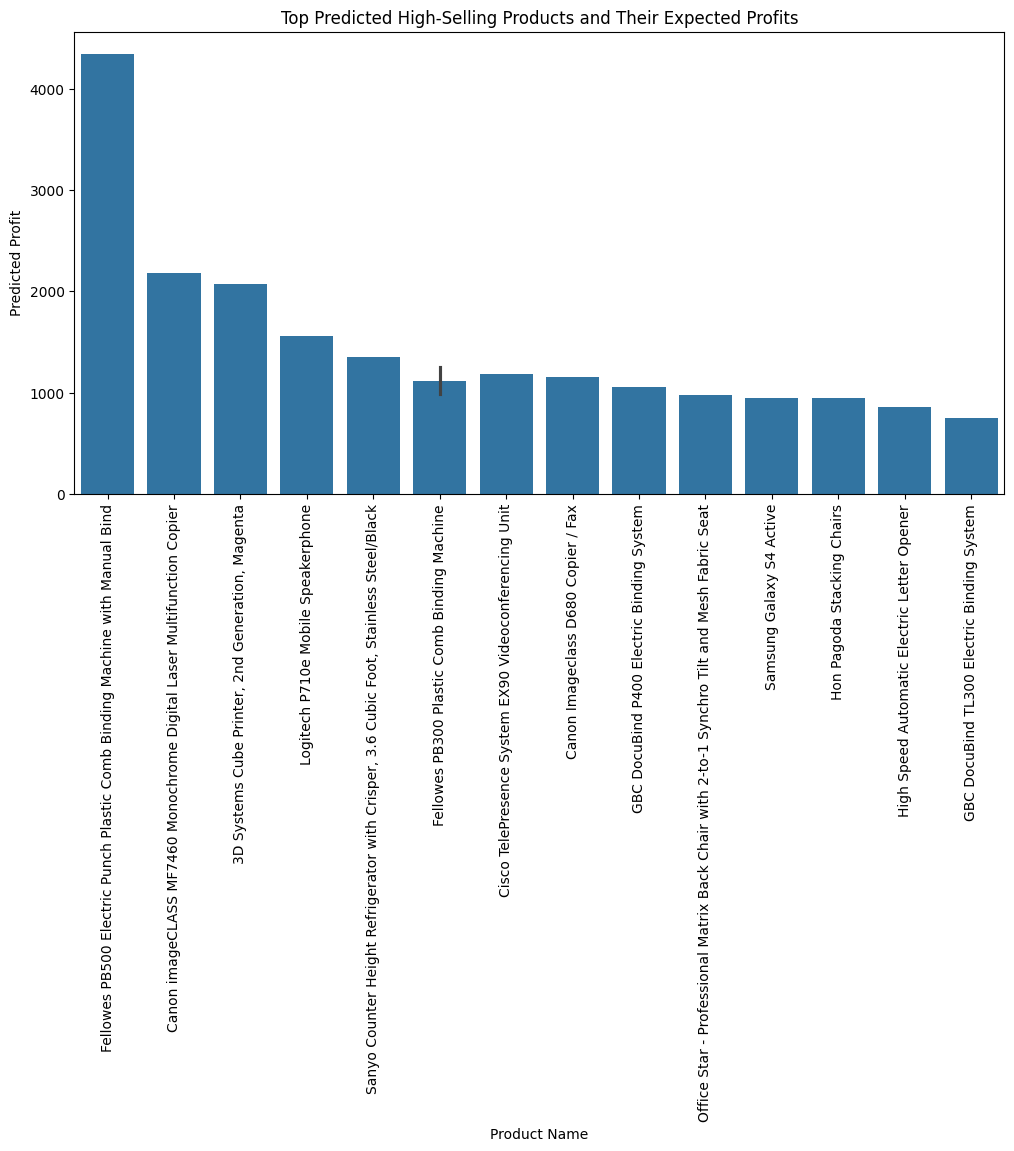

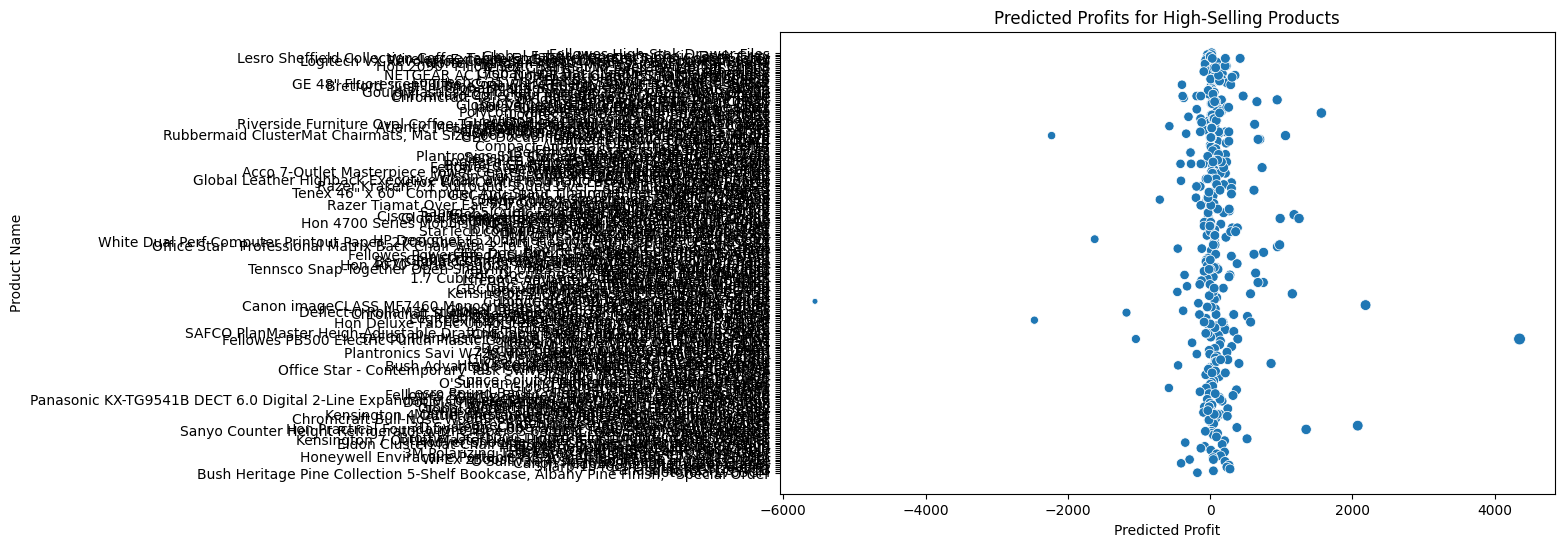

In [9]:
# 10. Visualize Predicted High Selling Products and Profits
# Align y_pred with X_test indices to avoid IndexError
if 'y_pred' in locals():
    y_pred_series = pd.Series(y_pred, index=X_test.index)
    X_test_cls['Predicted_Profit'] = y_pred_series.loc[X_test_cls.index]
else:
    X_test_cls['Predicted_Profit'] = 0

X_test_cls['Pred_High_Seller'] = y_pred_cls
X_test_cls['Product ID'] = df.iloc[X_test_cls.index]['Product ID'].values
X_test_cls['Product Name'] = df.iloc[X_test_cls.index]['Product Name'].values

high_selling_pred = X_test_cls[X_test_cls['Pred_High_Seller'] == 1]

plt.figure(figsize=(12,6))
high_selling_pred_sorted = high_selling_pred.sort_values('Predicted_Profit', ascending=False).head(15)
sns.barplot(data=high_selling_pred_sorted, x='Product Name', y='Predicted_Profit')
plt.title('Top Predicted High-Selling Products and Their Expected Profits')
plt.xticks(rotation=90)
plt.ylabel('Predicted Profit')
plt.xlabel('Product Name')
plt.show()

# Scatter plot: Sales vs. Predicted Profit for high sellers
plt.figure(figsize=(10,6))
sns.scatterplot(data=high_selling_pred, x='Predicted_Profit', y='Product Name', size='Predicted_Profit', legend=False)
plt.title('Predicted Profits for High-Selling Products')
plt.xlabel('Predicted Profit')
plt.ylabel('Product Name')
plt.show()

In [10]:
# Save all predicted data to 'future.csv'
predicted_df = X_test_cls.copy()
predicted_df['Actual_Profit'] = df.iloc[X_test_cls.index]['Profit'].values

# Align y_pred with X_test indices to avoid IndexError
if 'y_pred' in locals():
    y_pred_series = pd.Series(y_pred, index=X_test.index)
    predicted_df['Predicted_Profit'] = y_pred_series.loc[X_test_cls.index]
else:
    predicted_df['Predicted_Profit'] = 0

predicted_df['Pred_High_Seller'] = y_pred_cls
predicted_df['Product ID'] = df.iloc[X_test_cls.index]['Product ID'].values
predicted_df['Product Name'] = df.iloc[X_test_cls.index]['Product Name'].values
predicted_df['Order Date'] = df.iloc[X_test_cls.index]['Order Date'].values
predicted_df['Sales'] = df.iloc[X_test_cls.index]['Sales'].values
predicted_df['Quantity'] = df.iloc[X_test_cls.index]['Quantity'].values
predicted_df['Discount'] = df.iloc[X_test_cls.index]['Discount'].values
predicted_df['Category'] = df.iloc[X_test_cls.index]['Category'].values
predicted_df['Sub-Category'] = df.iloc[X_test_cls.index]['Sub-Category'].values
predicted_df['Region'] = df.iloc[X_test_cls.index]['Region'].values
predicted_df['Segment'] = df.iloc[X_test_cls.index]['Segment'].values
predicted_df['Ship Mode'] = df.iloc[X_test_cls.index]['Ship Mode'].values

# Save to future.csv
predicted_df[['Product ID', 'Product Name', 'Predicted_Profit', 'Pred_High_Seller']].to_csv('future.csv', index=False)
print('Predicted data saved to future.csv')

Predicted data saved to future.csv
